In [1]:
import argparse
from pathlib import Path
import warnings
from typing import Dict

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import seaborn as sns
import torch
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from viv1t import data
from viv1t.utils import plot
from viv1t.utils import h5
from viv1t.utils import utils

plot.set_font()

matplotlib.rcParams["animation.embed_limit"] = 2**64

TICK_FONTSIZE = 10
LABEL_FONTSIZE = 11
TITLE_FONTSIZE = 12
FPS = 30
DPI = 180

DATA_DIR = Path("../data")
PLOT_DIR = Path("figures/data_visualization")
OUTPUT_DIR = Path("../runs/vivit/204_causal_viv1t")

### Load datasets

In [2]:
args = argparse.Namespace()
args.data_dir = DATA_DIR
args.mouse_ids = list(data.SENSORIUM)
args.seed = 1234
args.transform_input = 0
args.transform_output = 0
args.batch_size = 1
args.crop_frame = -1
args.limit_data = None
args.device = torch.device("cpu")
args.num_workers = 0
args.verbose = 2

train_ds, val_ds, _ = data.get_training_ds(
    args,
    data_dir=args.data_dir,
    mouse_ids=args.mouse_ids,
    batch_size=args.batch_size,
    device=args.device,
)
_, test_ds = data.get_submission_ds(
    args,
    data_dir=args.data_dir,
    mouse_ids=args.mouse_ids,
    batch_size=args.batch_size,
    device=args.device,
)

In [3]:
for mouse_id, mouse_ds in train_ds.items():
    tiers, counts = np.unique(mouse_ds.dataset.tiers, return_counts=True)
    tiers = [str(tier) for tier in tiers]
    tiers = dict(zip(tiers, counts))
    print(
        f"Mouse {mouse_id}\n"
        f"\tnum_neurons: {mouse_ds.dataset.num_neurons}\n"
        f"\ttrain size: {tiers['train']}\n"
        f"\tvalidation size: {tiers['validation']}\n"
        f"\tlive main size: {tiers['live_main']}\n"
        f"\tlive bonus size: {tiers['live_bonus']}\n"
        f"\tfinal bonus size: {tiers['final_bonus']}\n"
        f"\tfinal bonus size: {tiers['final_bonus']}\n"
    )

Mouse A
	num_neurons: 7440
	train size: 350
	validation size: 59
	live main size: 56
	live bonus size: 59
	final bonus size: 138
	final bonus size: 138

Mouse B
	num_neurons: 7928
	train size: 352
	validation size: 60
	live main size: 58
	live bonus size: 59
	final bonus size: 118
	final bonus size: 118

Mouse C
	num_neurons: 8285
	train size: 355
	validation size: 58
	live main size: 58
	live bonus size: 80
	final bonus size: 119
	final bonus size: 119

Mouse D
	num_neurons: 7671
	train size: 356
	validation size: 59
	live main size: 60
	live bonus size: 59
	final bonus size: 120
	final bonus size: 120

Mouse E
	num_neurons: 7495
	train size: 351
	validation size: 60
	live main size: 57
	live bonus size: 58
	final bonus size: 137
	final bonus size: 137

Mouse F
	num_neurons: 7863
	train size: 348
	validation size: 58
	live main size: 56
	live bonus size: 58
	final bonus size: 134
	final bonus size: 134

Mouse G
	num_neurons: 7908
	train size: 329
	validation size: 56
	live main size: 

In [4]:
# draw one sample from Mouse A train set
sample = train_ds["A"].dataset.__getitem__(0)
for k, v in sample.items():
    print(f"{k}: {v.shape if torch.is_tensor(v) else v}")

video: torch.Size([1, 300, 36, 64])
response: torch.Size([7440, 300])
behavior: torch.Size([2, 300])
pupil_center: torch.Size([2, 300])
mouse_id: A
trial_id: torch.Size([])
video_id: torch.Size([])
stimulus_id: torch.Size([])
tier: train


### Plot responses and behaviors

In [5]:
def animate_trial(
    video: np.ndarray,
    response: np.ndarray,
    behavior: np.ndarray,
    pupil_center: np.ndarray,
    num_neurons: int = 170,
    filename: Path = None,
):
    figure = plt.figure(figsize=(8, 6), dpi=120, facecolor="white")

    ax1 = figure.add_axes(rect=[0.01, 0.6, 0.5, 0.3])
    ax2 = figure.add_axes(rect=[0.01, 0.2, 0.5, 0.3])

    top, height, gap = 0.80, 0.1, 0.2
    ax3 = figure.add_axes(rect=[0.55, top, 0.4, height])
    ax4 = figure.add_axes(rect=[0.55, top - gap, 0.4, height])
    ax5 = figure.add_axes(rect=[0.55, top - 2 * gap, 0.4, height])
    ax6 = figure.add_axes(rect=[0.55, top - 3 * gap, 0.4, height])

    movie_xticks = np.linspace(0, video.shape[3] - 1, 4)
    movie_yticks = np.linspace(0, video.shape[2] - 1, 4)
    response_xticks = np.linspace(0, video.shape[1] - 1, 4)
    response_yticks = np.linspace(0, num_neurons - 1, 4)

    pupil_size_yticks = np.linspace(
        np.nanmin(behavior[0, :]), np.nanmax(behavior[0, :]), 2
    )
    speed_yticks = np.linspace(np.nanmin(behavior[1, :]), np.nanmax(behavior[1, :]), 2)
    pupil_center_x_yticks = np.linspace(
        np.nanmin(pupil_center[0, :]), np.nanmax(pupil_center[0, :]), 2
    )
    pupil_center_y_yticks = np.linspace(
        np.nanmin(pupil_center[1, :]), np.nanmax(pupil_center[1, :]), 2
    )

    video_aspect = video.shape[2] / video.shape[3]
    response_aspect = (video.shape[1] / num_neurons) * video_aspect

    def update(frame: int):
        ax1.cla()
        ax2.cla()
        # plot movie frame
        ax1.imshow(
            video[0, frame, :, :],
            cmap="gray",
            aspect="equal",
            vmin=0,
            vmax=255,
        )
        pos = ax1.get_position()
        ax1.text(
            x=0,
            y=pos.y1 + 0.15,
            s=f"Movie Frame: {frame:03d}",
            ha="left",
            va="center",
            fontsize=LABEL_FONTSIZE,
            transform=ax1.transAxes,
        )
        ax1.grid(linewidth=0)
        plot.set_xticks(
            ax1,
            ticks=movie_xticks,
            tick_labels=movie_xticks.astype(int),
            label="Width (px)",
            tick_fontsize=TICK_FONTSIZE,
            label_fontsize=LABEL_FONTSIZE,
        )
        plot.set_yticks(
            ax1,
            ticks=movie_yticks,
            tick_labels=movie_yticks.astype(int),
            label="Height (px)",
            tick_fontsize=TICK_FONTSIZE,
            label_fontsize=LABEL_FONTSIZE,
        )

        # plot response
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            ax2.imshow(
                response[:num_neurons, :frame], cmap="turbo", aspect=response_aspect
            )
        ax2.grid(linewidth=0)
        plot.set_xticks(
            ax2,
            ticks=response_xticks,
            tick_labels=response_xticks.astype(int),
            label="Movie frame",
            tick_fontsize=TICK_FONTSIZE,
            label_fontsize=LABEL_FONTSIZE,
        )
        plot.set_yticks(
            ax2,
            ticks=response_yticks,
            tick_labels=response_yticks.astype(int),
            tick_fontsize=TICK_FONTSIZE,
        )
        ax2.set_ylabel("Neuronal responses", fontsize=LABEL_FONTSIZE, labelpad=0)

        # behavior - pupil size
        ax3.plot(behavior[0, :frame], color="black", linewidth=1.5)
        plot.set_yticks(
            ax3,
            ticks=pupil_size_yticks,
            tick_labels=pupil_size_yticks.astype(int),
            tick_fontsize=TICK_FONTSIZE,
        )
        ax3.set_title("Pupil size", pad=1, fontsize=LABEL_FONTSIZE)

        # behavior - speed
        ax4.plot(behavior[1, :frame], color="black", linewidth=1.5)
        plot.set_yticks(
            ax4,
            ticks=speed_yticks,
            tick_labels=[f"{value:.0e}" for value in speed_yticks],
            tick_fontsize=TICK_FONTSIZE,
        )
        ax4.set_title("Locomotion speed", pad=1, fontsize=LABEL_FONTSIZE)

        # pupil center - horizontal
        ax5.plot(pupil_center[0, :frame], color="black", linewidth=1.5)
        plot.set_yticks(
            ax5,
            ticks=pupil_center_x_yticks,
            tick_labels=[f"{value:.01e}" for value in pupil_center_x_yticks],
            tick_fontsize=TICK_FONTSIZE,
        )
        ax5.set_title("Pupil center (x)", pad=1, fontsize=LABEL_FONTSIZE)

        # pupil center - horizontal
        ax6.plot(pupil_center[1, :frame], color="black", linewidth=1.5)
        plot.set_yticks(
            ax6,
            ticks=pupil_center_y_yticks,
            tick_labels=[f"{value:.01e}" for value in pupil_center_y_yticks],
            tick_fontsize=TICK_FONTSIZE,
        )
        ax6.set_title("Pupil center (y)", pad=1, fontsize=LABEL_FONTSIZE)

        for ax in [ax3, ax4, ax5, ax6]:
            plot.set_xticks(
                ax,
                ticks=response_xticks,
                tick_labels=response_xticks.astype(int),
                label="Movie frame" if ax == ax6 else None,
                tick_fontsize=TICK_FONTSIZE,
                label_fontsize=LABEL_FONTSIZE,
            )
            ax.grid(visible=False, which="major")
            sns.despine(ax=ax, trim=True)

    ani = animation.FuncAnimation(
        figure, update, frames=np.arange(video.shape[1]), interval=1000 / FPS
    )
    if filename is not None:
        filename.parent.mkdir(parents=True, exist_ok=True)
        ani.save(filename, fps=FPS, dpi=DPI, savefig_kwargs={"pad_inches": 0.1})
    plt.close(figure)

### Plot Mouse A train set

In [ ]:
for i in range(3):
    sample = train_ds["A"].dataset.__getitem__(i)
    animate_trial(
        video=sample["video"],
        response=sample["response"],
        behavior=sample["behavior"],
        pupil_center=sample["pupil_center"],
        filename=PLOT_DIR
        / "trial"
        / f'mouse{sample["mouse_id"]}'
        / "train"
        / f'trial_{sample["trial_id"]}.mp4',
    )

### Plot Mouse A validation set

In [ ]:
mouse_id = "A"
for i in range(3):
    sample = val_ds[mouse_id].dataset.__getitem__(i)
    animation = animate_trial(
        video=sample["video"],
        response=sample["response"],
        behavior=sample["behavior"],
        pupil_center=sample["pupil_center"],
        filename=f"figures/mouse{mouse_id}/val/trial{sample['trial_id']}.gif",
    )
    del animation

### Plot for abstract figure 

In [ ]:
def plot_frame(sample: Dict[str, np.ndarray], frame: int):
    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
    ax.imshow(
        sample["video"][0, frame, :, :],
        cmap="gray",
        aspect="equal",
        vmin=0,
        vmax=255,
    )
    # figure.text(
    #     x=0.88,
    #     y=0.76,
    #     s=f"Frame {frame+1}",
    #     ha="right",
    #     va="center",
    #     fontsize=10,
    #     color="white",
    #     alpha=1.0,
    # )
    ax.set_xticks([])
    ax.set_yticks([])
    mouse_id, trial_id = sample["mouse_id"], sample["trial_id"]
    # plt.show()
    plot.save_figure(
        figure,
        filename=PLOT_DIR
        / "frame"
        / f"mouse{mouse_id}"
        / f"trial{trial_id:03d}_frame{frame+1:03d}.svg",
        dpi=DPI,
        close=False,
    )
    plt.close(figure)

In [ ]:
for mouse_id in data.SENSORIUM_OLD:
    for i in range(3):
        # draw one sample from Mouse G validation set
        sample = val_ds[mouse_id].dataset.__getitem__(i, to_tensor=False)
        for i in [0, 1, 2, 299]:
            plot_frame(sample, frame=i)

In [ ]:
pupil_size = sample["behavior"][0]
speed = sample["behavior"][1]
pupil_center = sample["pupil_center"]
print(f"pupil size: {pupil_size[:3]}")
print(f"speed: {speed[:3]}")
print(f"pupil_center x: {pupil_center[0, :3]}")
print(f"pupil_center y: {pupil_center[1, :3]}")

print(f"pupil size: {pupil_size[-1]}")
print(f"speed: {speed[-1]}")
print(f"pupil_center x: {pupil_center[0, -1]}")
print(f"pupil_center y: {pupil_center[1, -1]}")

response = sample["response"] / np.std(sample["response"], axis=1, keepdims=True)
print(response.shape)
print(f"response: {response[:2, :3]}")
print(f"response: {response[:2, -1]}")

# Plot Figure 1 assets

In [2]:
mouse_id = "B"
tiers = data.get_tier_ids(data_dir=DATA_DIR, mouse_id=mouse_id)
for tier in ("train", "live_bonus", "final_bonus"):
    print(f"{tier}: {np.where(tiers == tier)[0]}")

train: [  0   1   3   5   7  14  21  25  26  30  32  34  35  37  38  39  40  41
  44  49  50  52  53  54  56  57  58  61  64  66  68  69  71  72  73  74
  78  79  81  83  84  85  88  90  91  92  93  95  96  98 100 103 104 105
 106 108 112 115 116 122 123 124 125 126 127 129 130 134 135 137 138 140
 142 147 148 150 155 156 160 161 163 164 167 171 172 174 175 176 178 179
 183 185 187 188 194 199 200 202 204 205 207 208 210 213 216 217 218 219
 224 226 228 229 234 238 242 243 244 245 251 254 257 258 259 261 262 264
 265 266 267 268 269 270 271 274 278 279 280 281 284 285 286 287 288 289
 290 292 293 294 297 299 300 305 306 307 308 310 311 312 315 316 317 322
 323 325 326 328 330 331 332 335 336 340 341 343 346 347 348 349 350 351
 352 354 356 357 358 359 362 363 364 366 367 368 369 370 376 379 380 381
 382 383 384 386 392 394 395 396 397 398 399 401 402 403 405 407 409 411
 413 415 416 417 419 420 422 424 426 429 430 431 436 437 438 441 442 444
 445 447 451 452 453 454 456 457 459 460 462

### Plot frames

In [706]:
mouse_id, trial_id = "B", 186
filename = PLOT_DIR / "video" / f"mouse{mouse_id}"
# trial_ids = np.where(tiers == "train")[0]
trial_ids = [2, 176]
for trial_id in trial_ids:
    video = np.load(
        DATA_DIR / data.MOUSE_IDS[mouse_id] / "data" / "videos" / f"{trial_id}.npy"
    )
    for frame in [0, 151, 299]:
        figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
        ax.imshow(
            video[:, :, frame],
            cmap="gray",
            aspect="equal",
            vmin=0,
            vmax=255,
        )
        # figure.text(
        #     x=0.88,
        #     y=0.76,
        #     s=f"Frame {frame+1}",
        #     ha="right",
        #     va="center",
        #     fontsize=10,
        #     color="white",
        #     alpha=1.0,
        # )
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_edgecolor("black")
            spine.set_linewidth(4)
        # plt.show()
        plot.save_figure(
            figure,
            filename=filename / f"trial{trial_id:03d}" / f"frame{frame+1:03d}.svg",
            dpi=DPI,
            close=False,
        )
        plt.close(figure)

### Plot traces

In [109]:
def plot_traces(
    filename: Path,
    response: np.ndarray,
    color: str,
    title: str | None = None,
    neuron_order: np.ndarray | None = None,
):
    response = (response / np.max(response, axis=1, keepdims=True)) * 0.05
    if neuron_order is not None:
        response = response[neuron_order]
    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(1.6, 1), dpi=DPI)
    num_neurons = 20
    offset = 0
    for i in range(num_neurons):
        ax.plot(
            response[i] + offset,
            linewidth=2,
            alpha=(1 / 1.15) ** i,
            clip_on=False,
            color=color,
            zorder=num_neurons - i,
        )
        offset += 0.02
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_ylabel("8k neuron", fontsize=11)
    # ax.yaxis.set_label_coords(0.036, 0.5)
    if title is not None:
        figure.text(x=0.51, y=-0.02, s=title, fontsize=12)
    scale_bar = AnchoredSizeBar(
        transform=ax.transData,
        size=30,
        label="1s",
        loc="center",
        frameon=False,
        pad=0,
        fontproperties={"size": 10},
        size_vertical=0.004,
        bbox_to_anchor=(0.095, -0.11),
        bbox_transform=ax.transAxes,
    )
    ax.add_artist(scale_bar)
    sns.despine(ax=ax, left=True, bottom=True)
    plt.show()
    plot.save_figure(figure, filename=filename, dpi=DPI)

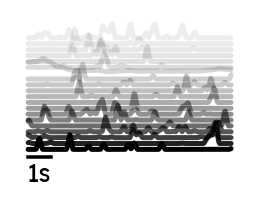

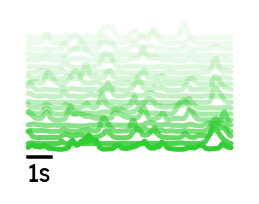

In [115]:
mouse_id, trial_id = "B", 83

neuron_order = utils.get_reliable_neurons(
    output_dir=OUTPUT_DIR, mouse_id=mouse_id, size=20
)
# Plot recorded response
response = np.load(
    DATA_DIR / data.MOUSE_IDS[mouse_id] / "data" / "responses" / f"{trial_id}.npy"
)
response = response[:, 50:300]
plot_traces(
    filename=PLOT_DIR
    / "response"
    / "recorded"
    / f"mouse{mouse_id}"
    / f"trial{trial_id:03d}.svg",
    response=response,
    color="black",
    # title="Recorded",
    neuron_order=neuron_order,
)

# Plot predicted response

response = h5.get(
    filename=OUTPUT_DIR / "responses" / f"mouse{mouse_id}.h5",
    trial_ids=[trial_id],
)[0]

plot_traces(
    filename=PLOT_DIR
    / "response"
    / "ViV1T"
    / f"mouse{mouse_id}"
    / f"trial{trial_id:03d}.svg",
    response=response,
    color="limegreen",
    # title="Predicted",
    neuron_order=neuron_order,
)

# Plot drifting Gabor

In [710]:
mouse_id, trial_id = "B", 2
filename = PLOT_DIR / "video" / f"mouse{mouse_id}"

video = np.load(
    DATA_DIR / data.MOUSE_IDS[mouse_id] / "data" / "videos" / f"{trial_id}.npy"
)
for frame in [0, 151, 299]:
    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
    ax.imshow(
        video[:, :, frame],
        cmap="gray",
        aspect="equal",
        vmin=0,
        vmax=255,
    )
    # figure.text(
    #     x=0.88,
    #     y=0.76,
    #     s=f"Frame {frame+1}",
    #     ha="right",
    #     va="center",
    #     fontsize=10,
    #     color="white",
    #     alpha=1.0,
    # )
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(4)
    # plt.show()
    plot.save_figure(
        figure,
        filename=filename / f"trial{trial_id:03d}" / f"frame{frame+1:03d}.svg",
        dpi=DPI,
        close=False,
    )
    plt.close(figure)

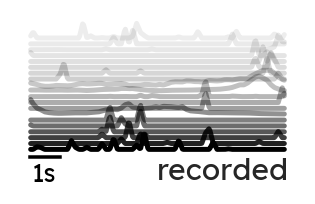

In [14]:
mouse_id, trial_id = "B", 2
filename = (
    PLOT_DIR / "response" / "recorded" / f"mouse{mouse_id}" / f"trial{trial_id:03d}.svg"
)

response = np.load(
    DATA_DIR / data.MOUSE_IDS[mouse_id] / "data" / "responses" / f"{trial_id}.npy"
)
response = response[:, 50:300]

response = (response / np.max(response, axis=1, keepdims=True)) * 0.05

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 1), dpi=DPI)

num_neurons = 20

colormap = matplotlib.colormaps.get_cmap("grey")
colors = [colormap(i) for i in np.linspace(0, 1, num_neurons)]

offset = 0
for i in range(num_neurons):
    ax.plot(
        response[i] + offset,
        linewidth=2,
        # alpha=0.8,
        alpha=(1 / 1.15) ** i,
        clip_on=False,
        # color=colors[i],
        color="black",
        zorder=num_neurons - i,
    )
    offset += 0.02

ax.set_xticks([])
ax.set_yticks([])
# ax.set_ylabel("neuron", fontsize=12)
# ax.yaxis.set_label_coords(0.036, 0.4)
figure.text(x=0.51, y=-0.02, s="recorded", fontsize=12)

scale_bar = AnchoredSizeBar(
    transform=ax.transData,
    size=30,
    label="1s",
    loc="center",
    frameon=False,
    pad=0,
    fontproperties={"size": 10},
    size_vertical=0.004,
    bbox_to_anchor=(0.095, -0.11),
    bbox_transform=ax.transAxes,
)
ax.add_artist(scale_bar)

sns.despine(ax=ax, left=True, bottom=True)

plt.show()
if filename is not None:
    plot.save_figure(
        figure,
        filename=filename,
        dpi=DPI,
        close=False,
    )

plt.close(figure)

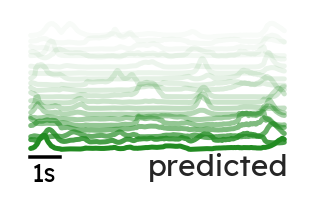

In [15]:
mouse_id, trial_id = "B", 2
filename = (
    PLOT_DIR / "response" / "ViV1T" / f"mouse{mouse_id}" / f"trial{trial_id:03d}.svg"
)
OUTPUT_DIR = Path("../runs/vivit/156_vivit_elu")

response = h5.get(
    filename=OUTPUT_DIR / "responses" / f"mouse{mouse_id}.h5",
    trial_ids=[trial_id],
)[0]

response = (response / np.max(response, axis=1, keepdims=True)) * 0.05

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 1), dpi=DPI)

num_neurons = 20

colormap = matplotlib.colormaps.get_cmap("grey")
colors = [colormap(i) for i in np.linspace(0, 1, num_neurons)]

offset = 0
for i in range(num_neurons):
    ax.plot(
        response[i] + offset,
        linewidth=2,
        # alpha=0.8,
        alpha=(1 / 1.2) ** i,
        clip_on=False,
        # color=colors[i],
        color="forestgreen",
        zorder=num_neurons - i,
    )
    offset += 0.02

ax.set_xticks([])
ax.set_yticks([])
# ax.set_ylabel("neuron", fontsize=12)
# ax.yaxis.set_label_coords(0.036, 0.4)
figure.text(x=0.485, y=0.0, s="predicted", fontsize=12)

scale_bar = AnchoredSizeBar(
    transform=ax.transData,
    size=30,
    label="1s",
    loc="center",
    frameon=False,
    pad=0,
    fontproperties={"size": 10},
    size_vertical=0.004,
    bbox_to_anchor=(0.095, -0.11),
    bbox_transform=ax.transAxes,
)
ax.add_artist(scale_bar)

sns.despine(ax=ax, left=True, bottom=True)

plt.show()
if filename is not None:
    plot.save_figure(
        figure,
        filename=filename,
        dpi=DPI,
        close=False,
    )

plt.close(figure)

# Plot directional pink noise

In [716]:
mouse_id, trial_id = "B", 42
filename = PLOT_DIR / "video" / f"mouse{mouse_id}"

video = np.load(
    DATA_DIR / data.MOUSE_IDS[mouse_id] / "data" / "videos" / f"{trial_id}.npy"
)
for frame in [0, 151, 299]:
    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
    ax.imshow(
        video[:, :, frame],
        cmap="gray",
        aspect="equal",
        vmin=0,
        vmax=255,
    )
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(4)
    plot.save_figure(
        figure,
        filename=filename / f"trial{trial_id:03d}" / f"frame{frame+1:03d}.svg",
        dpi=DPI,
        close=False,
    )
    plt.close(figure)

### Plot image

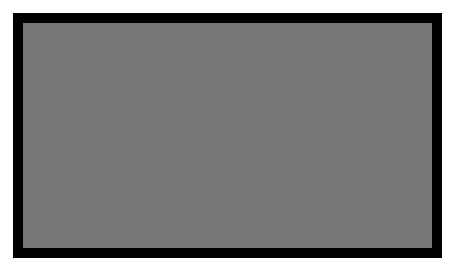

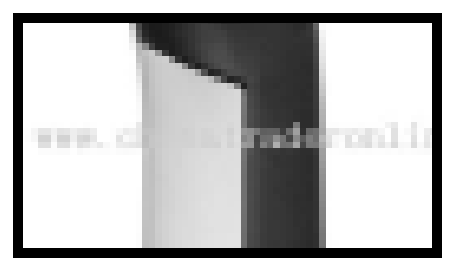

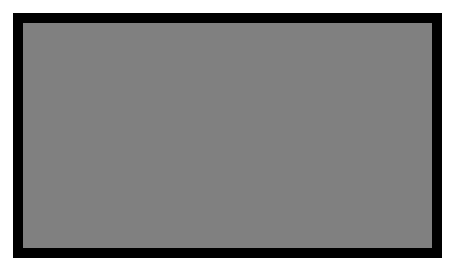

In [768]:
mouse_id, trial_id = "B", 673
filename = PLOT_DIR / "video" / f"mouse{mouse_id}"

video = np.load(
    DATA_DIR / data.MOUSE_IDS[mouse_id] / "data" / "videos" / f"{trial_id}.npy"
)
for frame in [0, 151, 299]:
    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
    ax.imshow(
        video[:, :, frame],
        cmap="gray",
        aspect="equal",
        vmin=0,
        vmax=255,
    )
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(4)
    plot.save_figure(
        figure,
        filename=filename / f"trial{trial_id:03d}" / f"frame{frame+1:03d}.svg",
        dpi=DPI,
        close=False,
    )
    plt.show()
    plt.close(figure)

# Plot Gaussian dots

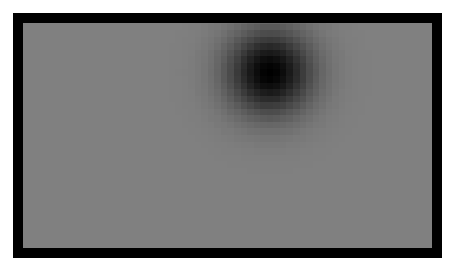

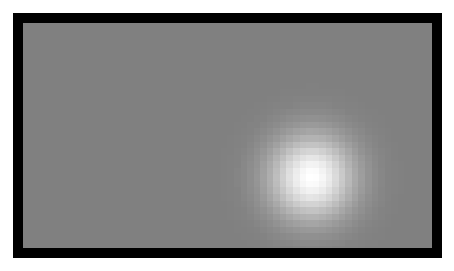

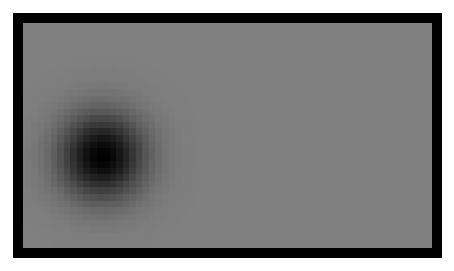

In [769]:
mouse_id, trial_id = "A", 12
filename = PLOT_DIR / "video" / f"mouse{mouse_id}"

video = np.load(
    DATA_DIR / data.MOUSE_IDS[mouse_id] / "data" / "videos" / f"{trial_id}.npy"
)
for frame in [0, 151, 299]:
    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
    ax.imshow(
        video[:, :, frame],
        cmap="gray",
        aspect="equal",
        vmin=0,
        vmax=255,
    )
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(4)
    plot.save_figure(
        figure,
        filename=filename / f"trial{trial_id:03d}" / f"frame{frame+1:03d}.svg",
        dpi=DPI,
        close=False,
    )
    plt.show()
    plt.close(figure)

# Plot random dots

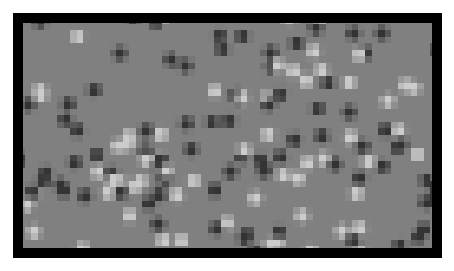

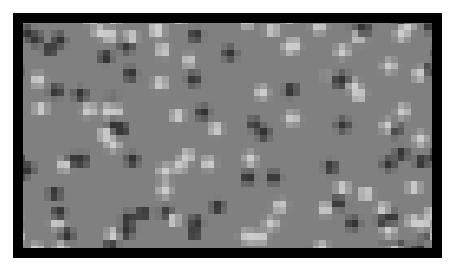

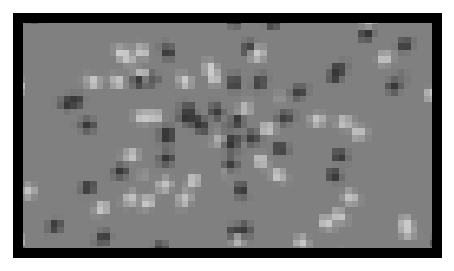

In [774]:
mouse_id, trial_id = "A", 38
filename = PLOT_DIR / "video" / f"mouse{mouse_id}"

video = np.load(
    DATA_DIR / data.MOUSE_IDS[mouse_id] / "data" / "videos" / f"{trial_id}.npy"
)
for frame in [0, 151, 200]:
    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
    ax.imshow(
        video[:, :, frame],
        cmap="gray",
        aspect="equal",
        vmin=0,
        vmax=255,
    )
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(4)
    plot.save_figure(
        figure,
        filename=filename / f"trial{trial_id:03d}" / f"frame{frame+1:03d}.svg",
        dpi=DPI,
        close=False,
    )
    plt.show()
    plt.close(figure)